# 总结：

分别使用end2end训练和pretrained的mobilenet提取照片的隐层feature，通过一个全连接层对照片进行美观度的打分。

整体分类准确率基本维持在72%-73%之间。其中：
1. 正样本预测准确率为71%，召回率为76%
2. 负样本预测准确率为74%，召回率为70%

## 训练

In [1]:
from keras.models import Model, Sequential, save_model, load_model
from keras.layers import Input, Dense, Activation, Add, Lambda, Concatenate, Reshape, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras import optimizers
import keras.backend as K
import numpy as np

Using TensorFlow backend.


In [2]:
aesthetic_fea = Input(shape=(1024, ))
semantic_fea = Input(shape=(1024, ))

merge_fea = Concatenate()([aesthetic_fea, semantic_fea])

x = Dense(1024, activation="selu")(merge_fea)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
    
output = Dense(1, activation="linear")(x)

aesthetic_model = Model(inputs=[aesthetic_fea, semantic_fea], outputs=output)

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
aesthetic_model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['mae'])

aesthetic_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1024)          0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1024)          0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 2048)          0           input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          2098176     concatenate_1[0][0]     

In [8]:
import pandas as pd
import lmdb
import random

trainset = pd.read_csv("./data/train.lst", 
                       dtype={"imgid": np.str, "rating": np.float, "label": np.int}).values.tolist()
testset = pd.read_csv("./data/test.lst", 
                      dtype={"imgid": np.str, "rating": np.float, "label": np.int}).values.tolist()

aesthetic_env = lmdb.open("../generic_features/data/aesthetic_features_on_regression.lmdb/")
semantic_env = lmdb.open("../generic_features/data/semantic_features.lmdb/")
aesthetic_txn = aesthetic_env.begin()
semantic_txn = semantic_env.begin()

batch_size = 64

def get_feature(imgid):
    aes_feature = np.fromstring(aesthetic_txn.get(imgid), np.float32)
    sem_feature = np.fromstring(semantic_txn.get(imgid), np.float32)
    return aes_feature, sem_feature

def generate_batch(dataset, batch_size, shuffle=True):
    while True:
        if shuffle:
            random.shuffle(dataset)
            
        for index in range(0, len(dataset), batch_size):
            if index + batch_size > len(dataset):
                current_batch_size = len(dataset) - index
            else:
                current_batch_size = batch_size
            index_array = dataset[index:index+current_batch_size]
            
            batch_x1 = np.zeros((current_batch_size, 1024), dtype=K.floatx())
            batch_x2 = np.zeros((current_batch_size, 1024), dtype=K.floatx())
            batch_y = np.zeros((current_batch_size, ), dtype=K.floatx())
            for i, (imgid, rating, label) in enumerate(index_array):
                x1, x2 = get_feature(imgid)
                batch_x1[i] = x1
                batch_x2[i] = x2
                batch_y[i] = rating
            yield ([batch_x1, batch_x2], batch_y)

In [9]:
aesthetic_model.fit_generator(generate_batch(trainset, batch_size), 
                              steps_per_epoch=len(trainset) // batch_size, 
                              validation_data=generate_batch(testset, batch_size), 
                              validation_steps=len(testset) // batch_size,
                              epochs=10)

Epoch 1/10
3530/3530 [==============================] - 15s - loss: 0.3544 - mean_absolute_error: 0.4665 - val_loss: 0.4225 - val_mean_absolute_error: 0.4723
Epoch 2/10
3530/3530 [==============================] - 16s - loss: 0.3524 - mean_absolute_error: 0.4648 - val_loss: 0.3566 - val_mean_absolute_error: 0.4539
Epoch 3/10
3530/3530 [==============================] - 15s - loss: 0.3508 - mean_absolute_error: 0.4640 - val_loss: 0.3708 - val_mean_absolute_error: 0.4623
Epoch 4/10
3530/3530 [==============================] - 16s - loss: 0.3489 - mean_absolute_error: 0.4626 - val_loss: 0.3565 - val_mean_absolute_error: 0.4607
Epoch 5/10
3530/3530 [==============================] - 16s - loss: 0.3479 - mean_absolute_error: 0.4619 - val_loss: 0.3651 - val_mean_absolute_error: 0.4591
Epoch 6/10
3530/3530 [==============================] - 16s - loss: 0.3452 - mean_absolute_error: 0.4602 - val_loss: 0.3617 - val_mean_absolute_error: 0.4666
Epoch 7/10
3530/3530 [==============================

In [10]:
aesthetic_model.save_weights("./model/ensemble_model_on_regression.h5")

## 预测

In [11]:
aesthetic_model.load_weights("./model/ensemble_model_on_regression.h5")

In [12]:
testset = pd.read_csv("./data/test.lst", 
                      dtype={"imgid": np.str, "rating": np.float, "label": np.int})

imgids = testset.imgid.values
ratings = testset.rating.values
labels = testset.label.values
probs = aesthetic_model.predict_generator(generate_batch(testset.values.tolist(), batch_size, shuffle=False),
                                  steps = len(testset) // batch_size + 1)[:, 0]
#preds = (probs > 0.5).astype(np.int)
probs[probs>10]=10
probs[probs<0]=0

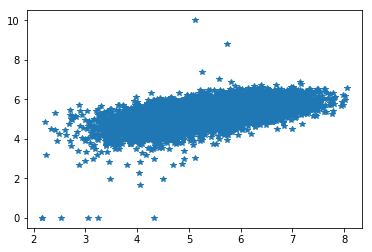

Spearman: 0.599


In [13]:
%matplotlib inline
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

plt.plot(ratings, probs, "*")
plt.show()

print "Spearman: %.3f"%spearmanr(ratings, probs)[0]

In [ ]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import random

n_view = 20
img_path = "../dataset/AVA/imgs/"
def imgPlot(imgid, title):
    plt.figure()
    
    plt.title("%s"%title)
    img = Image.open(img_path+"%s.jpg"%imgid)
    plt.imshow(img)
    plt.axis('off')
    
    plt.show()

- The images we most confident were beautiful, and are actually beautiful

In [ ]:
correct_imgs = np.where((preds==1) & (labels==1))[0]
most_correct_imgs = np.argsort(probs[correct_imgs])[::-1][:n_view]
for idx in correct_imgs[most_correct_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The images we most confident were ugly, and are actually ugly

In [ ]:
correct_imgs = np.where((preds==0) & (labels==0))[0]
most_correct_imgs = np.argsort(probs[correct_imgs])[:n_view]
for idx in correct_imgs[most_correct_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(1-probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The images we most confident were beautiful, but are actually ugly

In [ ]:
incorrect_imgs = np.where((preds==1) & (labels==0))[0]
most_incorrect_imgs = np.argsort(probs[incorrect_imgs])[::-1][:n_view]
for idx in incorrect_imgs[most_incorrect_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The images we most confident were ugly, but are actually beautiful

In [ ]:
incorrect_imgs = np.where((preds==0) & (labels==1))[0]
most_incorrect_imgs = np.argsort(probs[incorrect_imgs])[:n_view]
for idx in incorrect_imgs[most_incorrect_imgs]:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(1-probs[idx], ratings[idx])
    imgPlot(imgid, title)

- The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
most_uncertain = np.argsort(np.abs(probs-0.5))[:n_view]
for idx in most_uncertain:
    imgid = imgids[idx]
    title = "%.4f, %.2f"%(probs[idx], ratings[idx])
    imgPlot(imgid, title)

- confusion matrix

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(labels, preds)
print(cm)
plot_confusion_matrix(cm, ["ugly", "beautiful"], normalize=True)

In [ ]:
cm.astype('float') / cm.sum(axis=0)